# **Implementation of the K-Nearest Neighbour Algoritm**

### **Setup**

In [54]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Importing necessary modules
from datetime import timedelta
from time import perf_counter as tic

from matplotlib import pyplot as plt
import numpy as np

# Given helper functions
from utils import plotDatasets, loadDataset, splitData, splitDataBins, getCVSplit, plotResultsCV, plotResultsDots, plotConfusionMatrixOCR

# Implemented evaluation functions
from evalFunctions import calcConfusionMatrix, calcAccuracy, calcAccuracyCM

# Configure nice figures
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(8,5)

#### **Visualizing the Data**


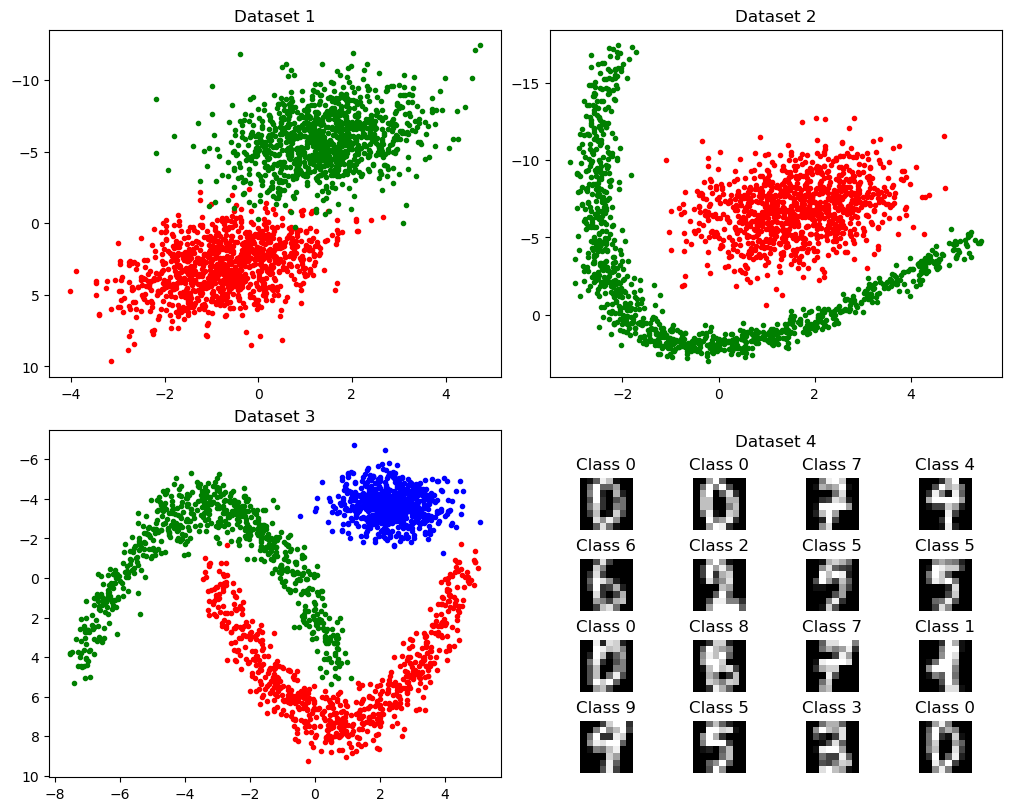

In [55]:
plotDatasets()

#### **Implementation of the kNN algorithm**



The algorithm iterates through each row (sample) in the feature matrix X and computes the Euclidean distance between the current test sample and all training samples (Xtrain). By using NumPy's argsort function, it identifies the indices of the nearest neighbors and the corresponding labels of these neighbors are determined. Using NumPy's unique function, the unique classes, their counts, and indices are obtained. 

For ties, the algorithm identifies the highest frequency of the class in the counts array and creates an array containing classes with the same counts (i.e., tied classes). Ties are handled with an if-statement, setting the datapoint to the class with the smallest Euclidean distance if there is a tie. If there is no tie, the current datapoint is set to the most frequent class and appended to LPred, the predicted labels array.

In [74]:
def kNN(X, k, XTrain, LTrain):

    classes = np.unique(LTrain)
    nClasses = classes.shape[0]
    LPred = []
    
    # Calculate all the distances between X and XTrain
    for i, row in enumerate(X):

        dists = np.sqrt( np.sum((row - XTrain) ** 2, axis=1))
        
        indNearest = np.argsort(dists)[0:k]
        classesNearest = LTrain[indNearest]

        uniqueClasses, indices, counts = np.unique(classesNearest, return_counts=True, return_index=True)

        #check for ties
        maxCount = np.max(counts)
        tiedClasses = uniqueClasses[counts == maxCount]

        #if tie
        if len(tiedClasses) > 1:
            mostCommonClass = uniqueClasses[np.min(indices)]
        else:
            # If no tie, choose the class with the maximum count
            mostCommonClass = uniqueClasses[np.argmax(counts)]

        # Find the most common label, store in LPred
        LPred.append(mostCommonClass)
    
    return np.array(LPred)

#### **Running k-NN Algorithm on Datasets**



Running the implemented kNN-algorithm on dataset 1-4. The results of running the algorithm on the train and test dataset is displayed in plots with correctly classified samples in green and wrongly classified samples in red. For dataset 4 the result is presented by a confusion matrix. 

In [75]:
def runkNNOnDataset(datasetNr, testSplit, k):
    # Loading the data
    X, D, L = loadDataset(datasetNr)

    # Splitting the data into input and target for both train and test dataset
    XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, testSplit)

    # Predicted labels for the train dataset
    LPredTrain = kNN(XTrain, k, XTrain, LTrain)
    # Predicted labels for the test dataset
    LPredTest = kNN(XTest, k, XTrain, LTrain)

    # Calculating the accuracy for the train dataset
    accTrain = calcAccuracy(LPredTrain, LTrain)
    # Calculating the accuracy for the test dataset
    accTest = calcAccuracy(LPredTest, LTest)
    # Calculating confusion matrix for the test data sets
    confMatrix = calcConfusionMatrix(LPredTest, LTest)
    
    print(f'Train accuracy: {accTrain:.4f}')
    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    # Plots the results using scatter plots for dataset 1-3
    if datasetNr < 4:
        plotResultsDots(XTrain, LTrain, LPredTrain, XTest, LTest, LPredTest, lambda X: kNN(X, k, XTrain, LTrain))
    # Plots the confusion matrix for dataset 4
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)

Train accuracy: 1.0000
Test accuracy: 0.9867
Test data confusion matrix:
[[156.   2.]
 [  2. 140.]]


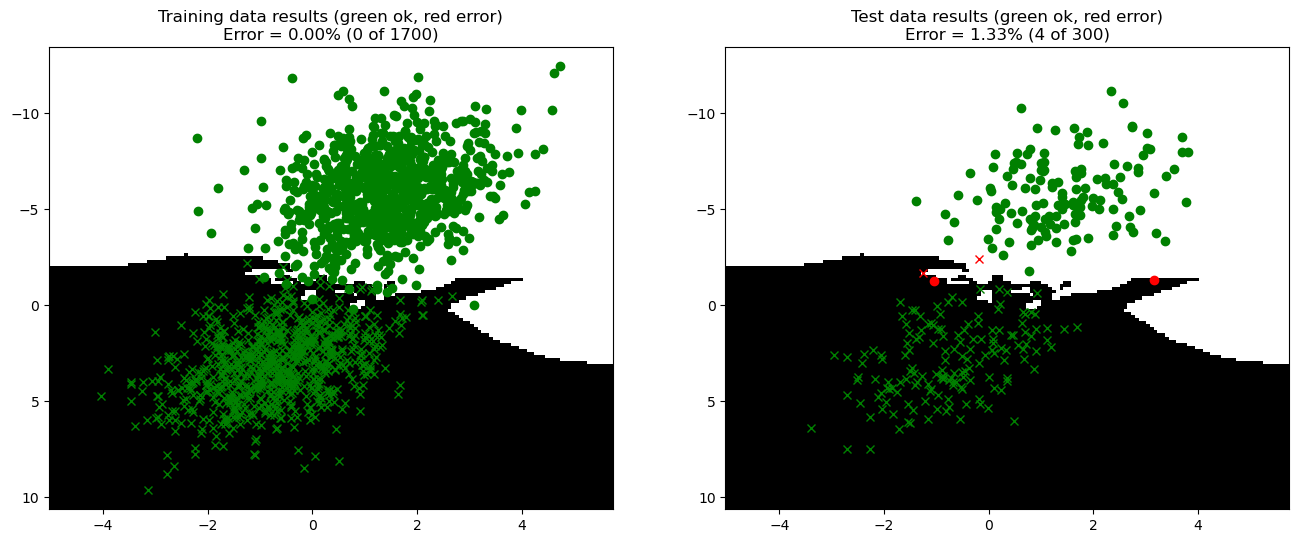

In [76]:
runkNNOnDataset(1, testSplit=0.15, k=1)

Train accuracy: 1.0000
Test accuracy: 1.0000
Test data confusion matrix:
[[146.   0.]
 [  0. 154.]]


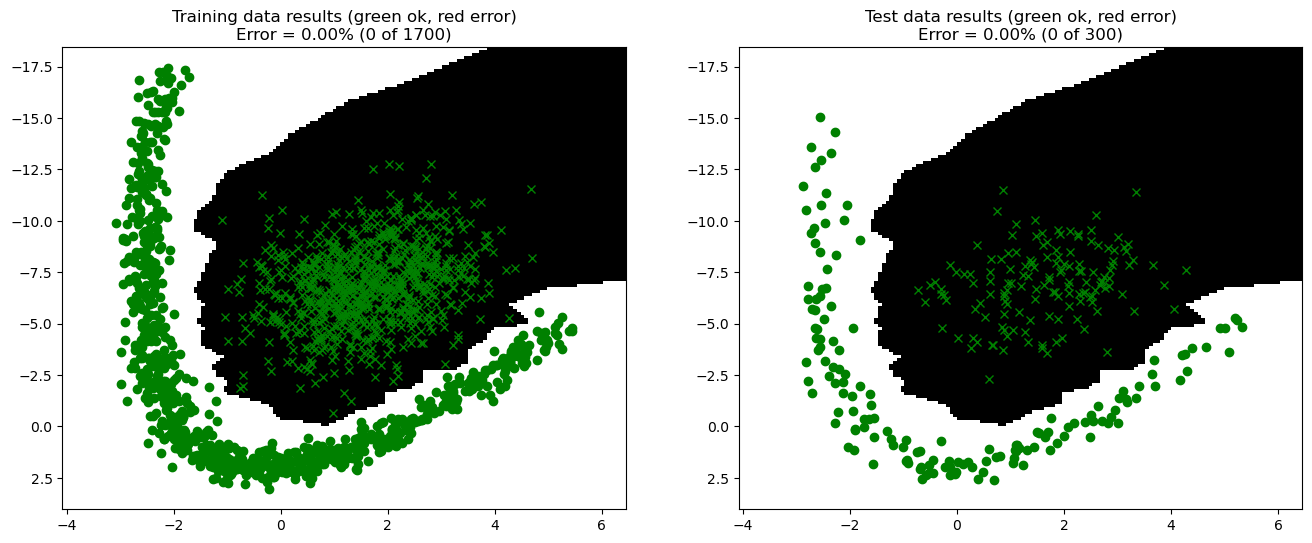

In [77]:
runkNNOnDataset(2, testSplit=0.15, k=1)

Train accuracy: 1.0000
Test accuracy: 0.9967
Test data confusion matrix:
[[100.   1.   0.]
 [  0. 106.   0.]
 [  0.   0.  93.]]


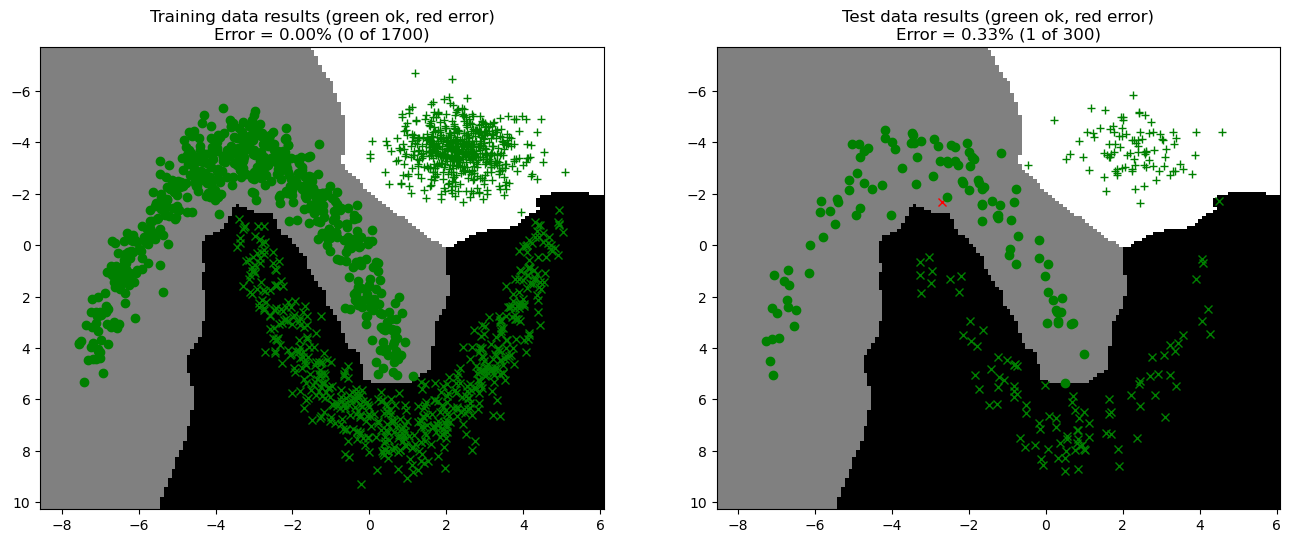

In [78]:
runkNNOnDataset(3, testSplit=0.15, k=1)

Train accuracy: 1.0000
Test accuracy: 0.9751
Test data confusion matrix:
[[426.   0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0. 426.   0.   0.   0.   0.   0.   1.   3.   0.]
 [  0.   3. 408.   1.   0.   0.   0.   1.   0.   0.]
 [  0.   3.   2. 406.   0.   3.   0.   1.   2.   3.]
 [  1.   5.   0.   0. 430.   0.   2.   1.   1.   2.]
 [  0.   1.   0.   5.   1. 393.   0.   0.   0.   3.]
 [  0.   1.   0.   0.   0.   0. 404.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0. 428.   0.   3.]
 [  1.  12.   1.   2.   0.   1.   2.   0. 388.   3.]
 [  0.   7.   0.   9.   5.   5.   0.   3.   3. 401.]]


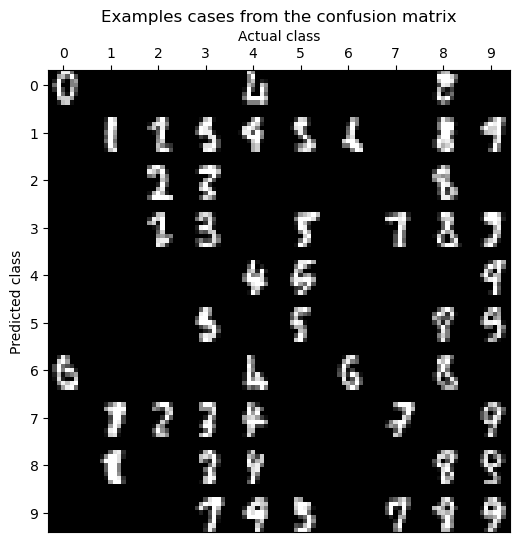

In [79]:
runkNNOnDataset(4, testSplit=0.75, k=1)

#### **Implementing cross-validation to find optimal K for each dataset**

The following section of code loads a dataset, splits it into training and test sets, selects the number of bins for data splitting, and then divides the training data into bins accordingly.

In [80]:
# Select and load dataset
datasetNr = 1
X, D, L = loadDataset(datasetNr)

# Split data into training and test sets
XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, 0.15)

# Select the number of bins to split the data
nBins = 50

# Split data into bins based on the settings above
# The outputs are lists of length nBins, where each item is a data array. Try printing for example XBins[0].shape.
XBins, _, LBins = splitDataBins(XTrain, None, LTrain, nBins)

 
The crossValidation function preforms k-fold cross-validation using kNN, with the aim to find the optimal value of k. It iterates over each bin of data, splitting it into training and validation sets, then tests different values of k from 1 to a specified maximum. For each combination of bin and k value, it performs kNN classification, computes the accuracy, and then returns the mean cross-validation accuracies for each k along with the best-performing k value.

In [81]:
def crossValiation(kMax, XBins, LBins):
    """Performs cross-validation using kNN

    Args:
        kMax (int): Maximum value of k to test. Values used will be [1-kMax].
        XBins (list of arrays): Training+validation data samples.
        LBins (list of arrays): Training+validation data labels.

    Returns:
        meanAccs (array): Cross-validation accuracies. Bins are in the rows, and
            values of k in the columns.
        kBest (int): Optimal value of k based on cross validation results.
    """

    nBins = len(XBins)
    accs = np.zeros((nBins, kMax))

    # This is used to show the progress
    timeStart = tic()
    
    for b in range(nBins):

        # Use getCVSplit to combine bins for training and validation data
        XTrain, DTrain, LTrain, XVal, DVal, LVal = getCVSplit(XBins, None, LBins, nBins, b)
        
        for k in range(1, kMax + 1):

            # Classify validation data using kNN
            preds = kNN(XVal, k, XTrain, LTrain)
            
            
            # ... and store resulting accuracy in the accs matrix
            accuracy = calcAccuracy(preds, LVal)
            accs[b, k - 1] = accuracy
            
            # Print progress and remaining time
            timeLeft = round((tic()-timeStart)*( nBins*kMax / (b*kMax + k + 1) - 1))
            etaStr = str(timedelta(seconds=timeLeft))
            print(f"b: {b+1:2}, k: {k+1:2}, ETA: {etaStr}    ", end="\r")
    
    # Compute the mean cross validation accuracy for each k
    meanAccs = np.mean(accs, axis=0)
    
    # And find the best k
    kBest    = np.argmax(meanAccs) + 1
    
    return meanAccs, kBest

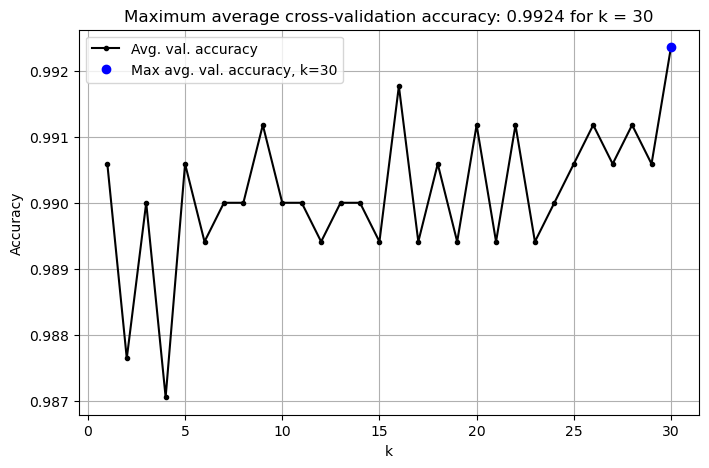

In [82]:
meanAccs, kBest = crossValiation(30, XBins, LBins)
plotResultsCV(meanAccs, kBest)

Using the optimal `k` received by cross-validation, `XTest` is classified using the data in `XTrain` as reference to get the test accuracy.

In [83]:
LPredTest = kNN(XTest, kBest, XTrain, LTrain)

confMatrix = calcConfusionMatrix(LPredTest, LTest)
acc = calcAccuracy(LPredTest, LTest)

print(f"Test accuracy: {acc:.4f}")
print("Test data confusion matrix:")
print(confMatrix)

Test accuracy: 0.9933
Test data confusion matrix:
[[159.   0.]
 [  2. 139.]]


---
### **Cross validation for all datasets**

The following function performs all of the previous cross-validation for a given dataset and shows the results. It runs kNN cross-validation on a specified dataset, plots the results, evaluates the model's performance on training and test data, prints the test accuracy and the confusion matrix. From this we get the optimal K for each dataset.

In [84]:
def runkNNCrossValidationOnDataset(datasetNr, testSplit, nBins, kMax):
    X, D, L = loadDataset(datasetNr)
    XTrain, _, LTrain, XTest, _, LTest = splitData(X, D, L, testSplit)
    XBins, _, LBins = splitDataBins(XTrain, None, LTrain, nBins)

    meanAccs, kBest = crossValiation(kMax, XBins, LBins)
    plotResultsCV(meanAccs, kBest)

    LPredTrain = kNN(XTrain, kBest, XTrain, LTrain)
    LPredTest = kNN(XTest, kBest, XTrain, LTrain)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)
    accTest = calcAccuracy(LPredTest, LTest)

    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        plotResultsDots(XTrain, LTrain, LPredTrain, XTest, LTest, LPredTest, lambda X: kNN(X, kBest, XTrain, LTrain))
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)
        

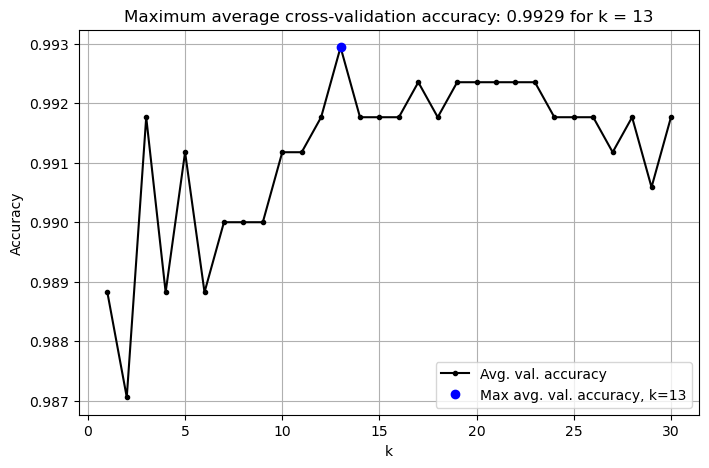

Test accuracy: 0.9833
Test data confusion matrix:
[[157.   4.]
 [  1. 138.]]


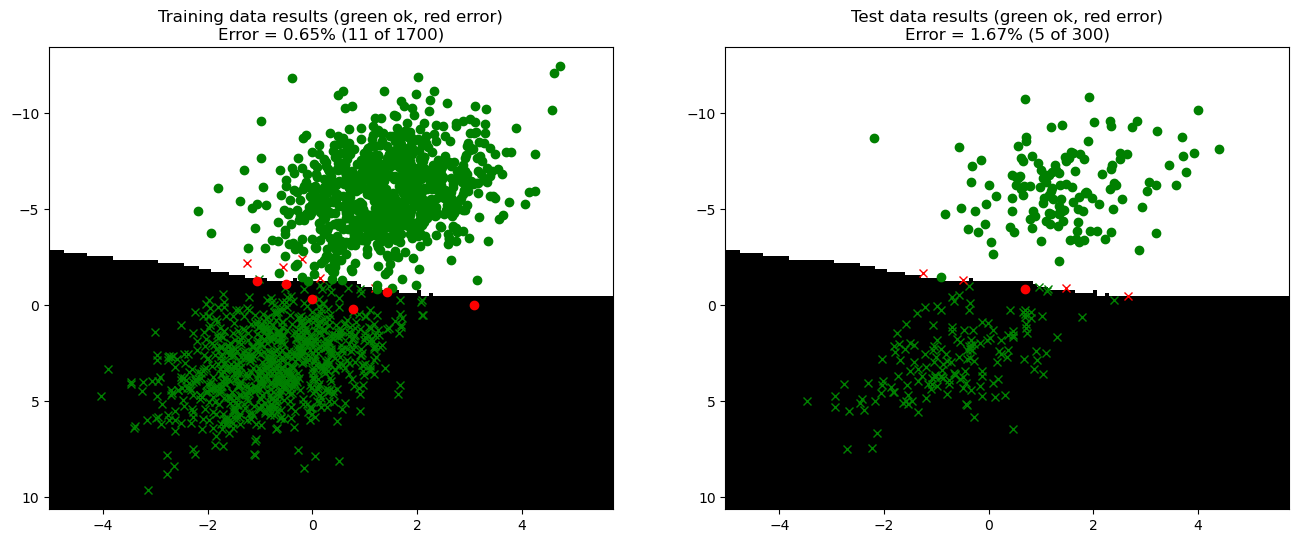

In [85]:
runkNNCrossValidationOnDataset(1, testSplit=0.15, nBins=20, kMax=30)

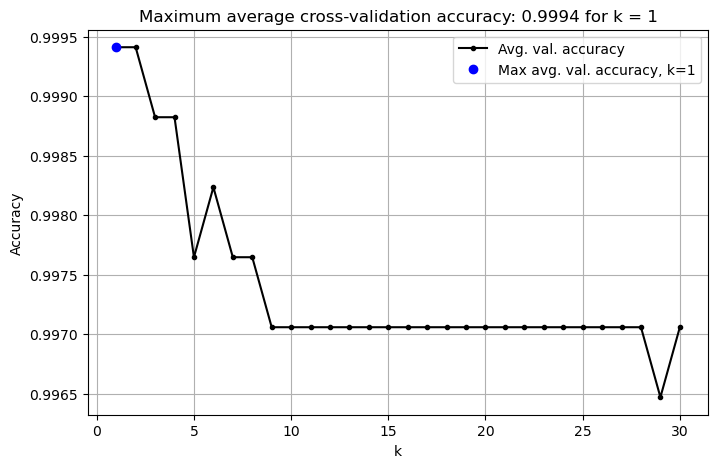

Test accuracy: 0.9967
Test data confusion matrix:
[[143.   1.]
 [  0. 156.]]


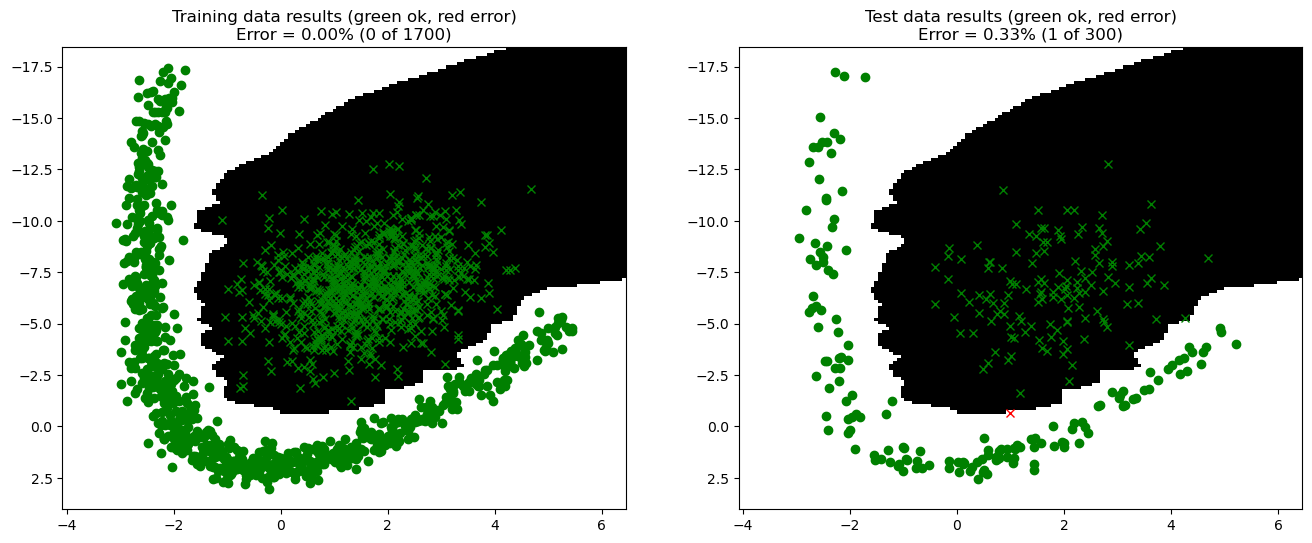

In [86]:
runkNNCrossValidationOnDataset(2, testSplit=0.15, nBins=20, kMax=30)

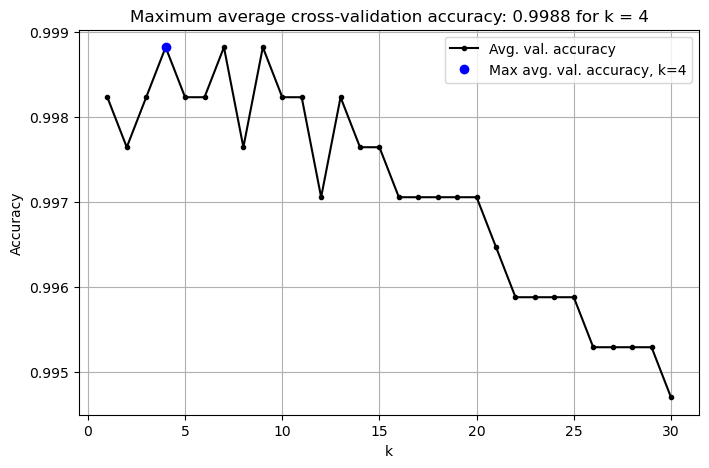

Test accuracy: 0.9967
Test data confusion matrix:
[[ 93.   1.   0.]
 [  0.  99.   0.]
 [  0.   0. 107.]]


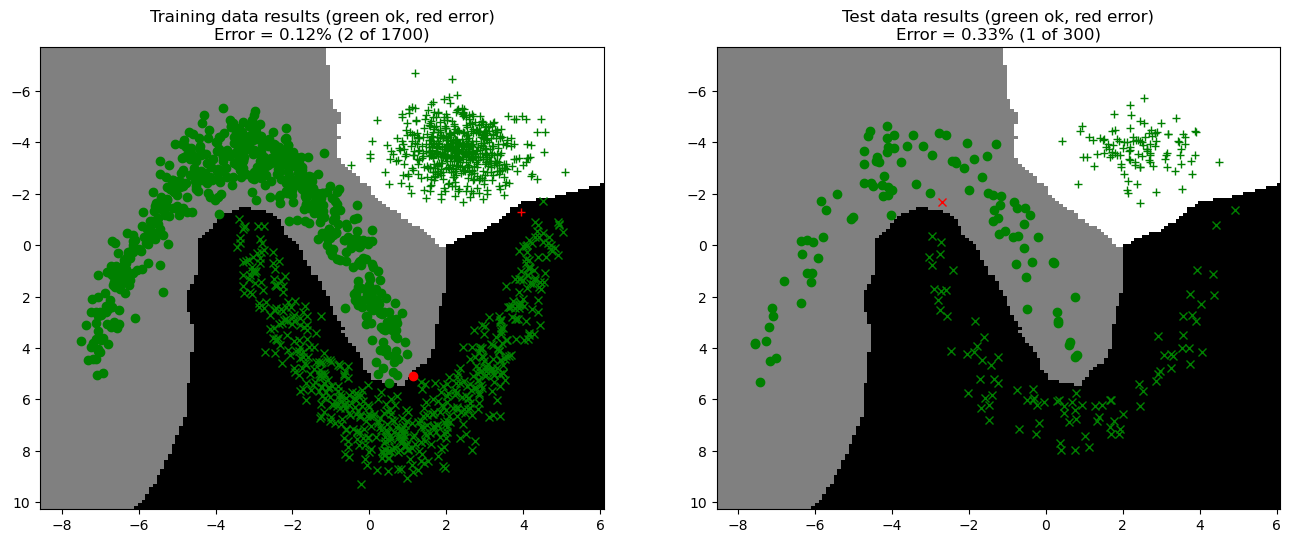

In [87]:
runkNNCrossValidationOnDataset(3, testSplit=0.15, nBins=20, kMax=30)

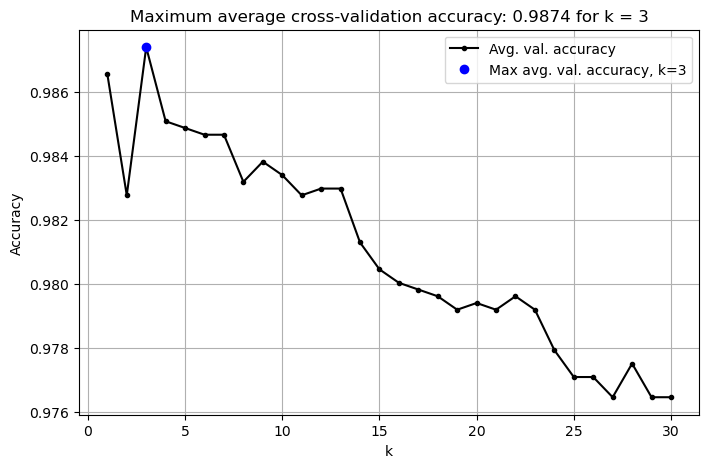

Test accuracy: 0.9893
Test data confusion matrix:
[[85.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0. 89.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 81.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 87.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0. 67.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 87.  0.  0.  0.  3.]
 [ 0.  1.  0.  0.  0.  0. 73.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 80.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  0. 89.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0. 96.]]


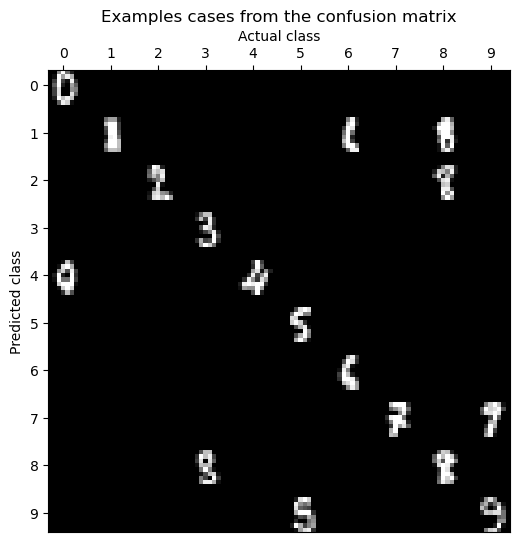

In [88]:
runkNNCrossValidationOnDataset(4, testSplit=0.15, nBins=20, kMax=30)